importing libraries

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



**loading dataset**

In [4]:
df =  pd.DataFrame(pd.read_excel(r'/content/drive/MyDrive/Online Retail.xlsx'))
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


**Data Cleaning**

In [5]:
df.dropna(subset =['CustomerID'], inplace = True)
df.reset_index(inplace =True, drop= True)

In [6]:
df['TotalPrice'] =df['UnitPrice']* df['Quantity']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   TotalPrice   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
df =df.drop_duplicates()

**Checking null values**

In [9]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalPrice,0


**Create Total Price**

In [10]:
df2 =df[(df.Quantity>0)&(df.UnitPrice>0)]

**Set Refernce Value**

In [11]:
ref_date = df['InvoiceDate'].max()
ref_date =pd.to_datetime(ref_date) + dt.timedelta(days=1)


**Calculating RFM dataframe**

In [12]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x:(ref_date - pd.to_datetime(x.max())).days ,
    'InvoiceNo' : 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm =rfm[rfm['Monetary']>0]

**Assign RFM score**

In [13]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5 , labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method= 'first'), 5 , labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5 , labels=[1,2,3,4,5])
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_SCORE'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)


**Segment Customer**

In [14]:
def segment_customer(df):
    R = int(df['R_score'])
    F = int(df['F_score'])
    M = int(df['M_score'])

    if df['RFM_score'] == '555':
        return 'Champions'
    elif R >= 4 and F >= 4:
        return 'Loyal Customers'
    elif R >= 4:
        return 'Recent Customers'
    elif F >= 4:
        return 'Frequent Buyers'
    elif M >= 4:
        return 'Big Spenders'
    else:
        return 'Others'


In [15]:
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [16]:
rfm['Segment']

,Segment
CustomerID,
12347.0,Loyal Customers
12348.0,Big Spenders
12349.0,Recent Customers
12350.0,Others
12352.0,Frequent Buyers
...,...
18280.0,Others
18281.0,Others
18282.0,Recent Customers


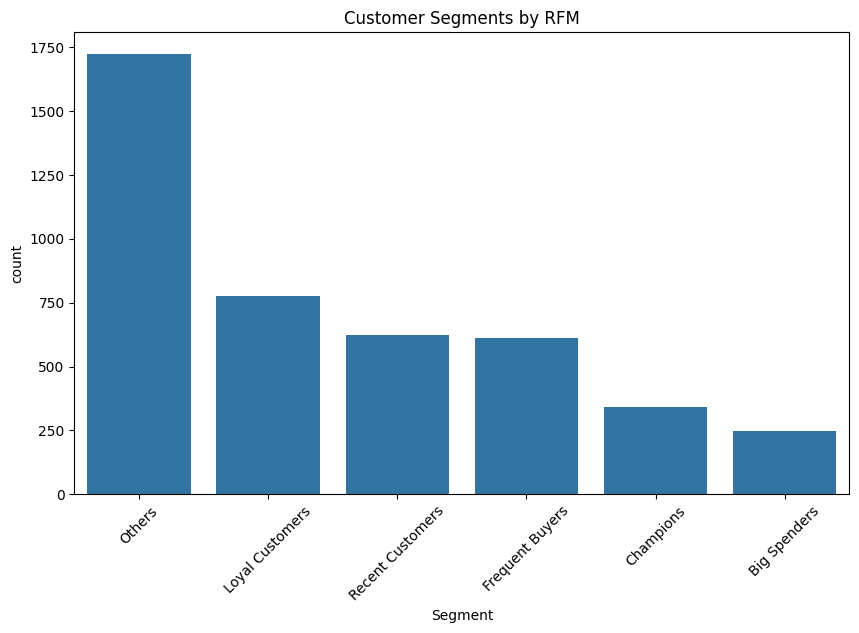

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments by RFM")
plt.xticks(rotation=45)
plt.show()


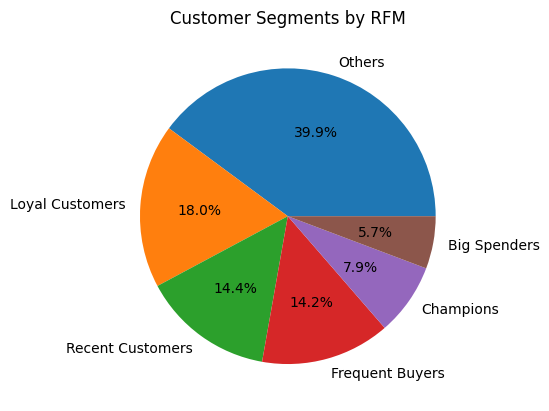

In [18]:
plt.pie(rfm['Segment'].value_counts(),
        labels=rfm['Segment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Customer Segments by RFM")
plt.show()


**Scale the Data**

In [19]:
scaler = StandardScaler()
rfm_Scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

**USe elbow method to find Optimal K**

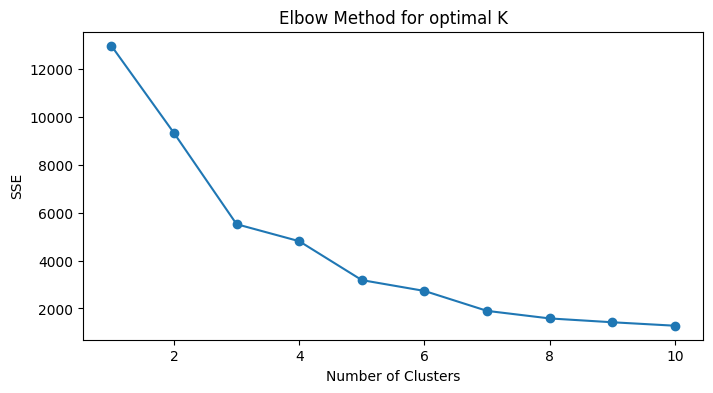

In [20]:
sse = []
k_range = range(1,11)
for k in k_range:
  kmeans = KMeans(n_clusters=k , random_state=42)
  kmeans.fit(rfm_Scaled)
  sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

**optimal number of clusters k**

In [21]:
optimal_k = 4


**Fit KMeans with the optimal k and assign clusters**

In [22]:
from sklearn.cluster import KMeans

# Use the optimal number of clusters from the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_Scaled)

# Assign cluster labels to your original RFM DataFrame
rfm['Cluster'] = kmeans.labels_


** Analyze the clusters**

In [23]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_summary)


        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         243.6       1.9    486.8  1077
1          39.8       5.6   1801.1  3220
2           1.3     213.7  66911.1     3
3           6.7      65.5  80319.8    22


**Visualize the clusters**

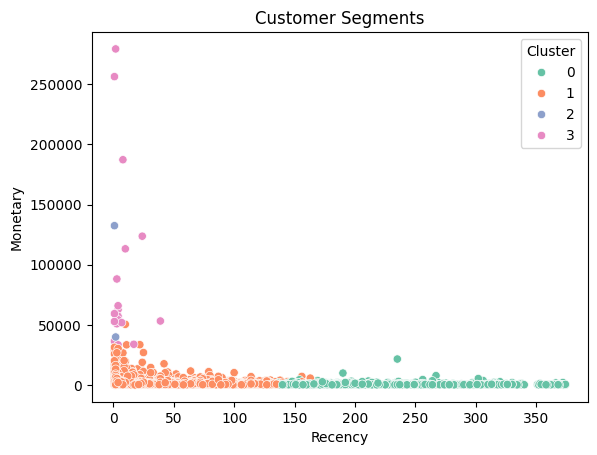

In [24]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments')
plt.show()

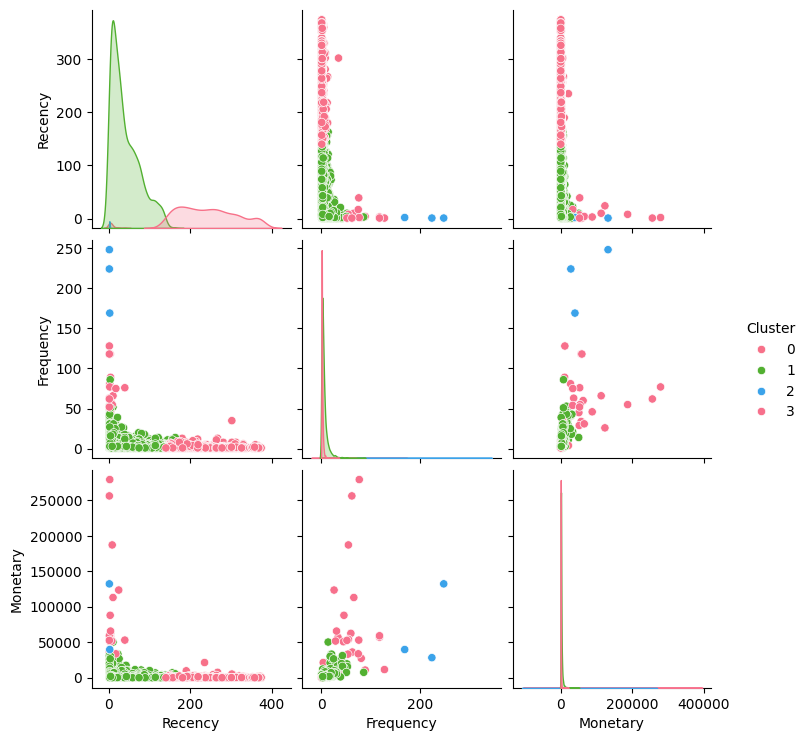

In [25]:
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='husl')


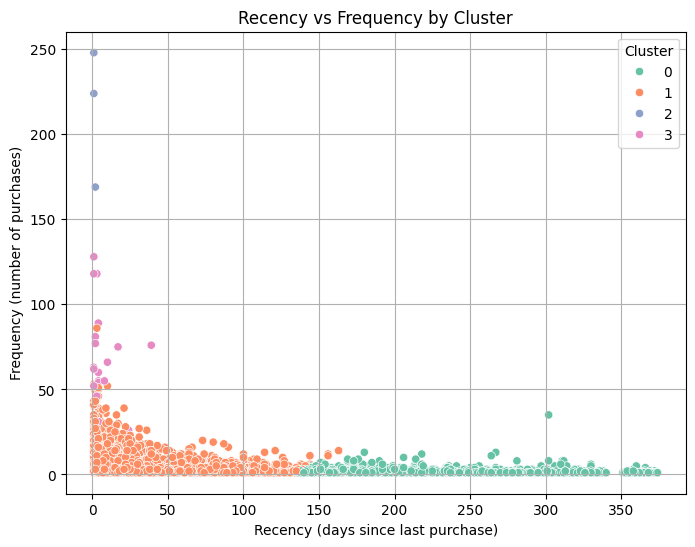

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2')
plt.title('Recency vs Frequency by Cluster')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (number of purchases)')
plt.grid(True)
plt.show()


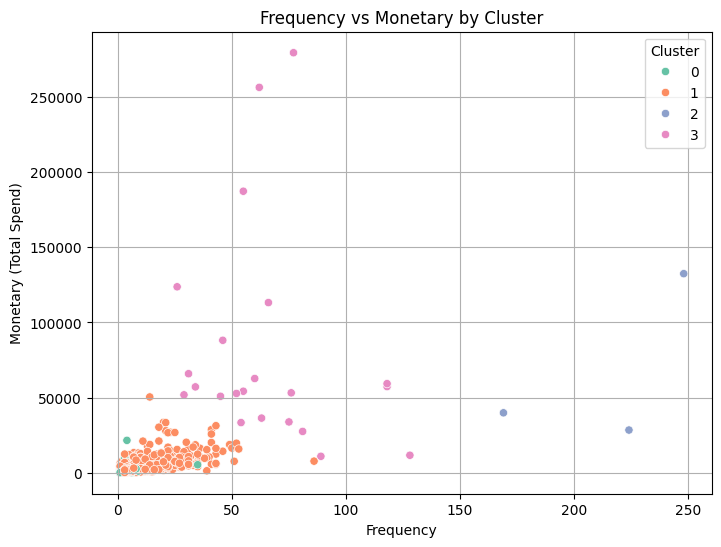

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Frequency vs Monetary by Cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary (Total Spend)')
plt.grid(True)
plt.show()


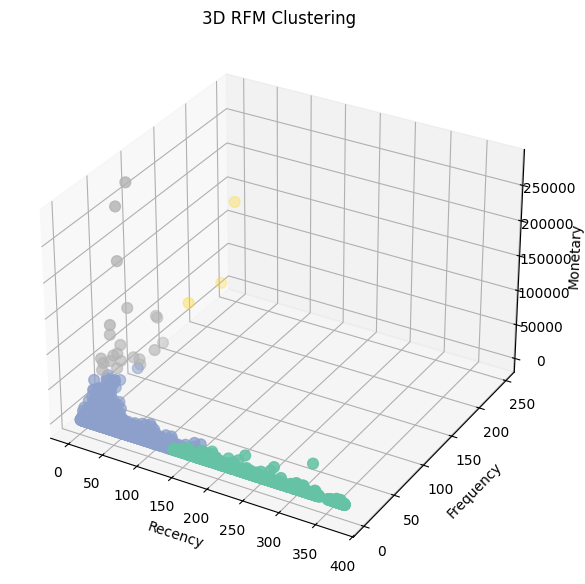

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=rfm['Cluster'], cmap='Set2', s=60)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Clustering')
plt.show()


In [29]:
rfm_scaled_df = pd.DataFrame(rfm_Scaled,
                             columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df['Cluster'] = rfm['Cluster'].values

In [30]:
rfm_melted = pd.melt(rfm_scaled_df,
                     id_vars=['Cluster'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Metric',
                     value_name='Value')


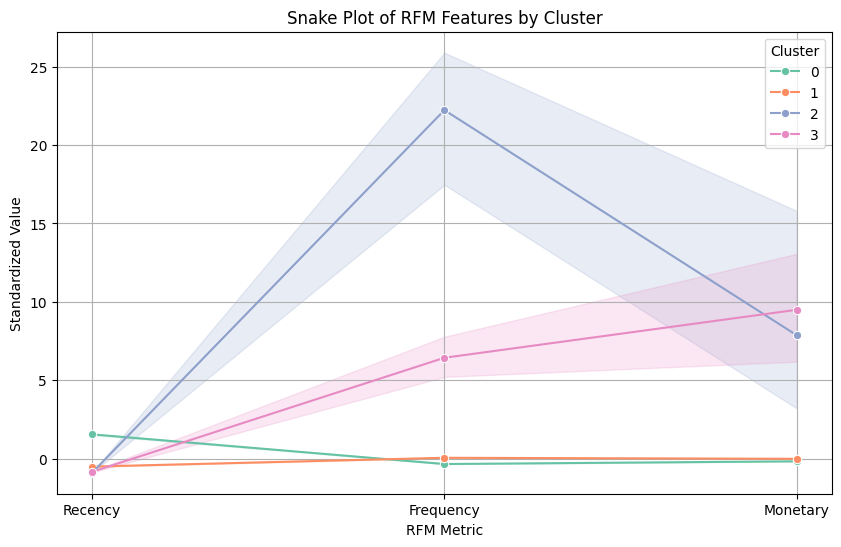

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=rfm_melted, x='Metric', y='Value', hue='Cluster', marker='o', palette='Set2')
plt.title('Snake Plot of RFM Features by Cluster')
plt.xlabel('RFM Metric')
plt.ylabel('Standardized Value')
plt.grid(True)
plt.show()


In [32]:
# 5. Define Score Levels
def assign_score_label(score):
    if score >= 13:
        return 'Platinum'
    elif score >= 10:
        return 'Gold'
    elif score >= 7:
        return 'Silver'
    else:
        return 'Bronze'

rfm['Score'] = rfm['RFM_SCORE'].apply(assign_score_label)

In [33]:
rfm.reset_index(inplace=True)

In [34]:
rfm.rename(columns={'Monetary': 'MonetaryValue'}, inplace=True)

In [35]:
final_df = rfm[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'Cluster', 'R_score', 'F_score', 'M_score',
                'RFM_score', 'RFM_SCORE', 'Segment', 'Score']]

# Display the table
print(final_df.head())

   CustomerID  Recency  Frequency  MonetaryValue  Cluster R_score F_score  \
0     12347.0        2          7        4310.00        1       5       4   
1     12348.0       75          4        1797.24        1       2       3   
2     12349.0       19          1        1757.55        1       4       1   
3     12350.0      310          1         334.40        0       1       1   
4     12352.0       36         11        1545.41        1       3       5   

  M_score RFM_score  RFM_SCORE           Segment     Score  
0       5       545         14   Loyal Customers  Platinum  
1       4       234          9      Big Spenders    Silver  
2       4       414          9  Recent Customers    Silver  
3       2       112          4            Others    Bronze  
4       4       354         12   Frequent Buyers      Gold  
